In [2]:
# 신경망 구축과 데이터셋을 위한 torch, torchvision import

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
# Local 경로 설정

%cd ~/Desktop/Dataset/Pytorch

/Users/one/Desktop/Dataset/Pytorch


In [4]:
# CIFAR10를 이용해 데이터셋 만들기

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(root='.data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# GPU 가속 사용 확인

device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
print(f'{device} is available')

mps:0 is available


In [6]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 50, 5)
    self.pool1 = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(50, 100, 5)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(100*5*5, 120)
    self.fc2 = nn.Linear(120, 10)
    
  def forward(self, x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    
    x = x.view(-1, 100*5*5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    
    return x

net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(3, 50, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(50, 100, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2500, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

In [7]:
loss_ = []
n = len(trainloader)

for epoch in range(10):
  running_loss = 0.0

  for i, data in enumerate(trainloader, 0):
    
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    
  loss_.append(running_loss / n)
  print('[%d] loss %.3f' %(epoch + 1, running_loss / len(trainloader)))

[1] loss 1.764
[2] loss 1.184
[3] loss 0.964
[4] loss 0.816
[5] loss 0.702
[6] loss 0.602
[7] loss 0.514
[8] loss 0.435
[9] loss 0.356
[10] loss 0.285


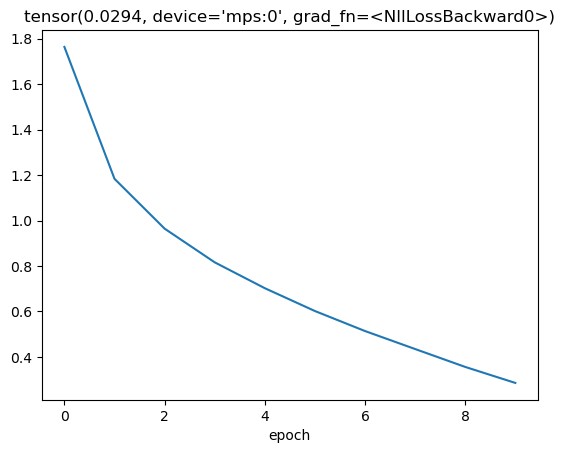

In [8]:
plt.plot(loss_)
plt.title(loss)
plt.xlabel('epoch')
plt.show()

In [9]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [10]:
net = Net().to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [11]:
correct = 0
total = 0

with torch.no_grad():
  for data in testloader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)

    total +=  labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'accuracy of 10000 test images : {100 * correct/total}%')

outputs.data

accuracy of 10000 test images : 11.28%


tensor([[0.0000, 0.0122, 0.0576, 0.0000, 0.0067, 0.0263, 0.0945, 0.0040, 0.1144,
         0.0261],
        [0.0000, 0.0084, 0.0000, 0.0000, 0.0209, 0.0291, 0.1023, 0.0213, 0.1260,
         0.0627],
        [0.0000, 0.0381, 0.0482, 0.0000, 0.0193, 0.0657, 0.1074, 0.0185, 0.1532,
         0.0633],
        [0.0000, 0.0106, 0.0000, 0.0000, 0.0406, 0.0472, 0.1026, 0.0446, 0.1492,
         0.0488],
        [0.0000, 0.0166, 0.0476, 0.0000, 0.0149, 0.0407, 0.0879, 0.0000, 0.1164,
         0.0390],
        [0.0000, 0.0202, 0.0459, 0.0000, 0.0233, 0.0331, 0.1245, 0.0010, 0.1105,
         0.0257],
        [0.0000, 0.0261, 0.0104, 0.0000, 0.0256, 0.0258, 0.0963, 0.0225, 0.1129,
         0.0131],
        [0.0000, 0.0378, 0.0461, 0.0000, 0.0235, 0.0401, 0.1061, 0.0000, 0.1055,
         0.0035]], device='mps:0')

In [12]:
predicted

tensor([8, 8, 8, 8, 8, 6, 8, 6], device='mps:0')